Purpose: To run PCA on 10 randomly selected individual BioProjects for QC purposes. Do the points group by replicates? By treatments?<br>
Author: Anna Pardo<br>
Date initiated: Nov. 15, 2023

In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

In [12]:
# first select the BioProjects
# Load metadata
md = pd.read_csv("../../data/srr_numbers_with_metadata_12-May-2023.csv",sep=",",header="infer")
md.head()

,BioProject,Sample,sample_name,Replicate_num,Genotype,Technology,Library_layout,Treatment,Duration_hours,Time_after_treatment,...,Developmental_stage,Tissue,Day_length_hours,Day_temp_C,Night_temp_C,Relative humidity (%),Light (umol/m2/s),Growth Env.,Media,Notes
0,PRJNA637522,SRR11933261,238_WS2,NaN,238,Illumina HiSeq 2500,PAIRED,Drought,312.0,13 days,...,V3,Leaf,16.0,25.0,NaN,NaN,NaN,Greenhouse,NaN,NaN
1,PRJNA637522,SRR11933272,238_WS1,NaN,238,Illumina HiSeq 2500,PAIRED,Drought,216.0,9 days,...,V3,Leaf,16.0,25.0,NaN,NaN,NaN,Greenhouse,NaN,NaN
2,PRJNA637522,SRR11933250,268_WS1,NaN,268,Illumina HiSeq 2500,PAIRED,Drought,216.0,9 days,...,V3,Leaf,16.0,25.0,NaN,NaN,NaN,Greenhouse,NaN,NaN
3,PRJNA637522,SRR11933029,268_WW,NaN,268,Illumina HiSeq 2500,PAIRED,Control,216.0,9 days,...,V3,Leaf,16.0,25.0,NaN,NaN,NaN,Greenhouse,NaN,NaN
4,PRJNA637522,SRR11933040,268_WS2,NaN,268,Illumina HiSeq 2500,PAIRED,Drought,312.0,13 days,...,V3,Leaf,16.0,25.0,NaN,NaN,NaN,Greenhouse,NaN,NaN


In [9]:
# pull out a list of all BioProjects
bp = md["BioProject"].unique()

In [26]:
# randomly select (no replacement) 10 BioProjects to look at and save them as a list
intbp = np.random.choice(bp,size=10,replace=False)
intbp

array(['PRJNA349117', 'PRJNA687609', 'PRJNA378714', 'Brandon_Webster',
       'PRJNA747925', 'PRJNA686250', 'PRJNA414300', 'PRJNA556806',
       'PRJNA587226', 'PRJNA576545'], dtype=object)

In [2]:
# load TPM matrix
tpm = pd.read_csv("../../data/rawtpm_bptreat_noPEG.tsv",sep="\t",header="infer")
tpm.head()

,Sample,BioProject,Treatment,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
0,SRR11933261,PRJNA637522,Drought,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,...,0.171184,0.000000,0.0,0.0,0.0,0.309501,0.0,0.000000,0.0,0.000000
1,SRR11933272,PRJNA637522,Drought,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,...,0.108052,0.127878,0.0,0.0,0.0,6.703281,0.0,0.000000,0.0,0.000000
2,SRR11933250,PRJNA637522,Drought,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.417565,0.0,0.254123,0.0,1.213349
3,SRR11933029,PRJNA637522,Control,8.201340,2.385748,0.000000,1.726808,1.926412,19.600487,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.370075
4,SRR11933040,PRJNA637522,Drought,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,...,0.178304,0.012158,0.0,0.0,0.0,9.625225,0.0,0.000000,0.0,2.352959


In [3]:
len(tpm["Sample"].unique())

1981

In [4]:
# define a function from an answer in https://stackoverflow.com/questions/39812885/retain-feature-names-after-scikit-feature-selection
def variance_threshold_selector(data):
    selector = VarianceThreshold()
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [13]:
# write a function to run and plot the PCA for a single BioProject

def run_pca(tpm,bioproject,metadata):
    print("Running PCA for BioProject",bioproject)
    # subset TPM dataframe to a single BioProject
    subtpm = tpm[tpm["BioProject"]==bioproject]
    # set Sample as index and drop BioProject and Treatment columns
    ttpm = subtpm.set_index("Sample").drop(["BioProject","Treatment"],axis=1)
    # put through VarianceThreshold() using the variance_threshold_selector() defined above
    vttpm = variance_threshold_selector(ttpm)
    # find how many zero-variance genes were eliminated
    print("Number of zero-variance genes eliminated:",len(ttpm.columns)-len(vttpm.columns))
    # log-transform TPM
    vttpm_log = vttpm.apply(lambda x: np.log2(x+1))
    # run PCA and generate dataframe with PCs
    pca = PCA(n_components=2)
    real_PCs = pca.fit_transform(vttpm_log)
    real_PCs_df = pd.DataFrame(data = real_PCs, columns = ['PC1','PC2'])
    # find the explained variance ratio
    print("PCA explained variance ratio:",pca.explained_variance_ratio_)
    ## reset index (after running PCA)
    vttpm_log.reset_index(inplace=True)
    vttpm_log.rename(columns={"index":"Sample"},inplace=True)
    # merge with metadata
    ## note this has to maintain the sample order of vttpm_log, otherwise when we concatenate it with the PC df everything will 
    ## be incorrectly matched up
    vttpm_log_merged = vttpm_log.merge(metadata,how="inner")
    # append metadata to PCA df
    plotdf = pd.concat([real_PCs_df,vttpm_log_merged[["BioProject","Genotype","Treatment","Time_after_treatment","Concentration",
                                                     "Developmental_stage","Tissue","Day_length_hours","Day_temp_C","Night_temp_C",
                                                     "Relative humidity (%)","Light (umol/m2/s)","Growth Env.","Media"]]],axis=1)
    # rename DroughtRepeat to Drought
    plotdf["Treatment"].mask(plotdf["Treatment"]=="DroughtRepeat","Drought",inplace=True)
    
    return plotdf
    

In [27]:
dfdict = {}
for b in intbp:
    dfdict[b] = run_pca(tpm,b,md)

Running PCA for BioProject PRJNA349117
Number of zero-variance genes eliminated: 4996
PCA explained variance ratio: [0.4579936  0.07233595]
Running PCA for BioProject PRJNA687609
Number of zero-variance genes eliminated: 7528
PCA explained variance ratio: [0.36206767 0.34625637]
Running PCA for BioProject PRJNA378714
Number of zero-variance genes eliminated: 11200
PCA explained variance ratio: [0.37263566 0.13712675]
Running PCA for BioProject Brandon_Webster
Number of zero-variance genes eliminated: 2111
PCA explained variance ratio: [0.1337533  0.07702483]
Running PCA for BioProject PRJNA747925
Number of zero-variance genes eliminated: 2783
PCA explained variance ratio: [0.16849183 0.13002954]
Running PCA for BioProject PRJNA686250
Number of zero-variance genes eliminated: 8093
PCA explained variance ratio: [0.83131722 0.0618685 ]
Running PCA for BioProject PRJNA414300
Number of zero-variance genes eliminated: 5727
PCA explained variance ratio: [0.45420484 0.29701337]
Running PCA for

In [30]:
dfdict['Brandon_Webster'].columns

Index(['PC1', 'PC2', 'BioProject', 'Genotype', 'Treatment',
       'Time_after_treatment', 'Concentration', 'Developmental_stage',
       'Tissue', 'Day_length_hours', 'Day_temp_C', 'Night_temp_C',
       'Relative humidity (%)', 'Light (umol/m2/s)', 'Growth Env.', 'Media'],
      dtype='object')

In [44]:
# for each BioProject: put all the relevant information together (i.e. treatment, genotype, etc. - for salt & LN, include
# concentration; for heat & cold, include day temp) to form a sample/replicate identifier

for b in dfdict.keys():
    df = dfdict[b].fillna("nodata")
    df["SampCondition"] = df["Genotype"]+"_"+df["Treatment"]+"_"+df["Time_after_treatment"]+"_"+df["Developmental_stage"]+"_"+df["Tissue"]
    if "Heat" in list(df["Treatment"].unique()):
        df["Sample_Condition"] = df["SampCondition"]+"_"+df["Day_temp_C"].astype(str)
    elif "Cold" in list(df["Treatment"].unique()):
        df["Sample_Condition"] = df["SampCondition"]+"_"+df["Day_temp_C"].astype(str)
    elif "Low_Nitrogen" in list(df["Treatment"].unique()):
        df["Sample_Condition"] = df["SampCondition"]+"_"+df["Concentration"]
    elif "Salt" in list(df["Treatment"].unique()):
        df["Sample_Condition"] = df["SampCondition"]+"_"+df["Concentration"]
    else:
        df["Sample_Condition"] = df["SampCondition"]
    dfdict[b] = df.drop("SampCondition",axis=1)
    
    

In [48]:
for b in dfdict.keys():
    print(b)
    print(len(dfdict[b]["Sample_Condition"].unique()))

PRJNA349117
24
PRJNA687609
4
PRJNA378714
4
Brandon_Webster
33
PRJNA747925
174
PRJNA686250
2
PRJNA414300
4
PRJNA556806
44
PRJNA587226
2
PRJNA576545
4


In [66]:
dfdict["PRJNA747925"].columns

Index(['PC1', 'PC2', 'BioProject', 'Genotype', 'Treatment',
       'Time_after_treatment', 'Concentration', 'Developmental_stage',
       'Tissue', 'Day_length_hours', 'Day_temp_C', 'Night_temp_C',
       'Relative humidity (%)', 'Light (umol/m2/s)', 'Growth Env.', 'Media',
       'Sample_Condition'],
      dtype='object')

In [67]:
dfdict["PRJNA747925"]["SampCon"] = dfdict["PRJNA747925"]["Treatment"]+"_"+dfdict["PRJNA747925"]["Time_after_treatment"]+"_"+dfdict["PRJNA747925"]["Developmental_stage"]+"_"+dfdict["PRJNA747925"]["Tissue"]
len(dfdict["PRJNA747925"]["SampCon"].unique())

27

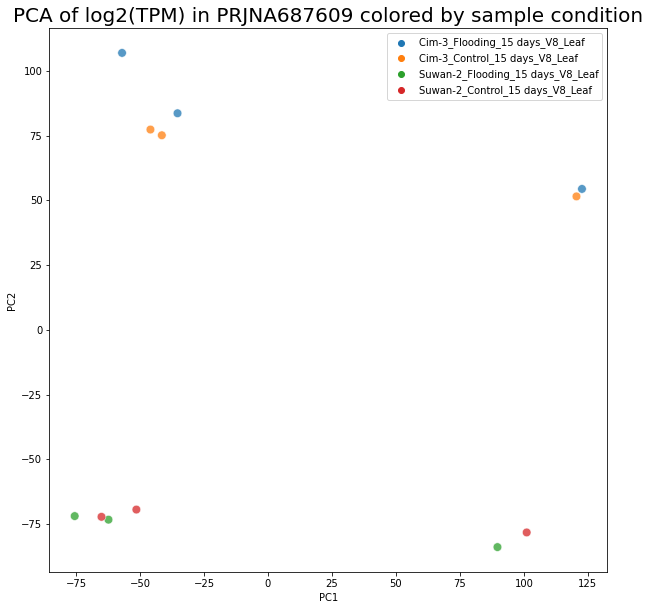

In [50]:
# plot PRJNA687609 by Sample_Condition
fig,ax=plt.subplots(figsize=(10,10))
sns.scatterplot(x=dfdict["PRJNA687609"]["PC1"],y=dfdict["PRJNA687609"]["PC2"],hue=dfdict["PRJNA687609"]["Sample_Condition"],
                palette="tab10",s=75,alpha=0.75)
plt.title("PCA of log2(TPM) in PRJNA687609 colored by sample condition",fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

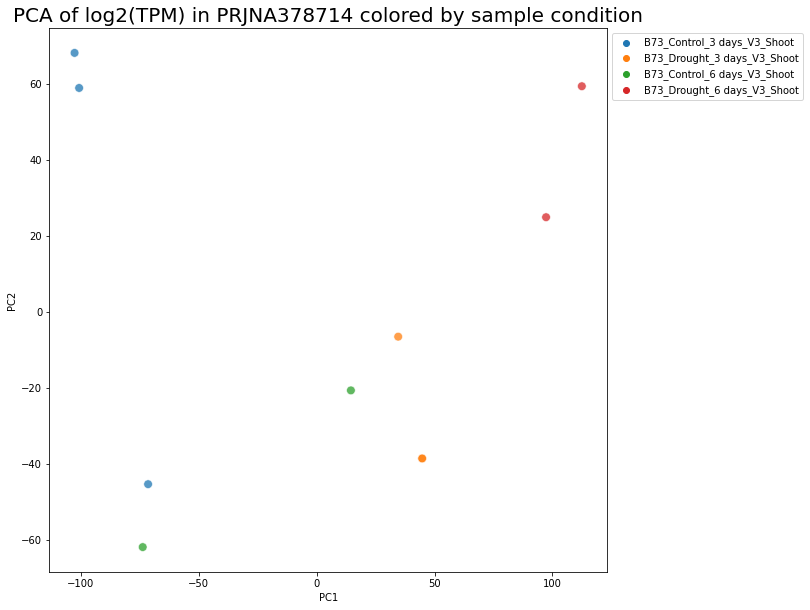

In [51]:
# plot PRJNA378714 by Sample_Condition
fig,ax=plt.subplots(figsize=(10,10))
sns.scatterplot(x=dfdict["PRJNA378714"]["PC1"],y=dfdict["PRJNA378714"]["PC2"],hue=dfdict["PRJNA378714"]["Sample_Condition"],
                palette="tab10",s=75,alpha=0.75)
plt.title("PCA of log2(TPM) in PRJNA378714 colored by sample condition",fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

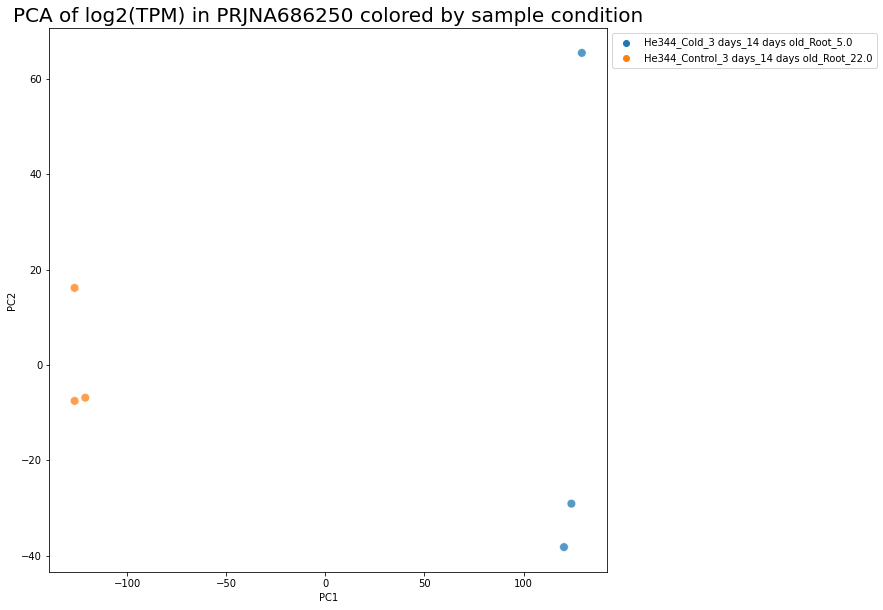

In [52]:
# plot PRJNA686250 by Sample_Condition
fig,ax=plt.subplots(figsize=(10,10))
sns.scatterplot(x=dfdict["PRJNA686250"]["PC1"],y=dfdict["PRJNA686250"]["PC2"],hue=dfdict["PRJNA686250"]["Sample_Condition"],
                palette="tab10",s=75,alpha=0.75)
plt.title("PCA of log2(TPM) in PRJNA686250 colored by sample condition",fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

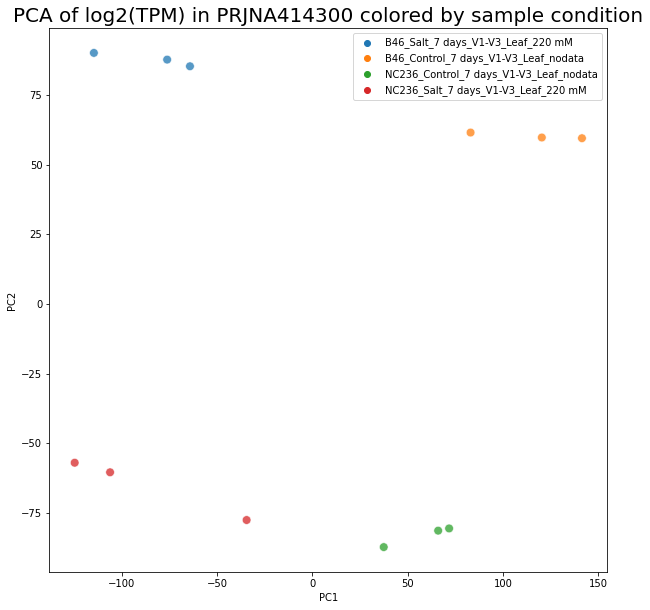

In [53]:
# plot PRJNA414300 by Sample_Condition
fig,ax=plt.subplots(figsize=(10,10))
sns.scatterplot(x=dfdict["PRJNA414300"]["PC1"],y=dfdict["PRJNA414300"]["PC2"],hue=dfdict["PRJNA414300"]["Sample_Condition"],
                palette="tab10",s=75,alpha=0.75)
plt.title("PCA of log2(TPM) in PRJNA414300 colored by sample condition",fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

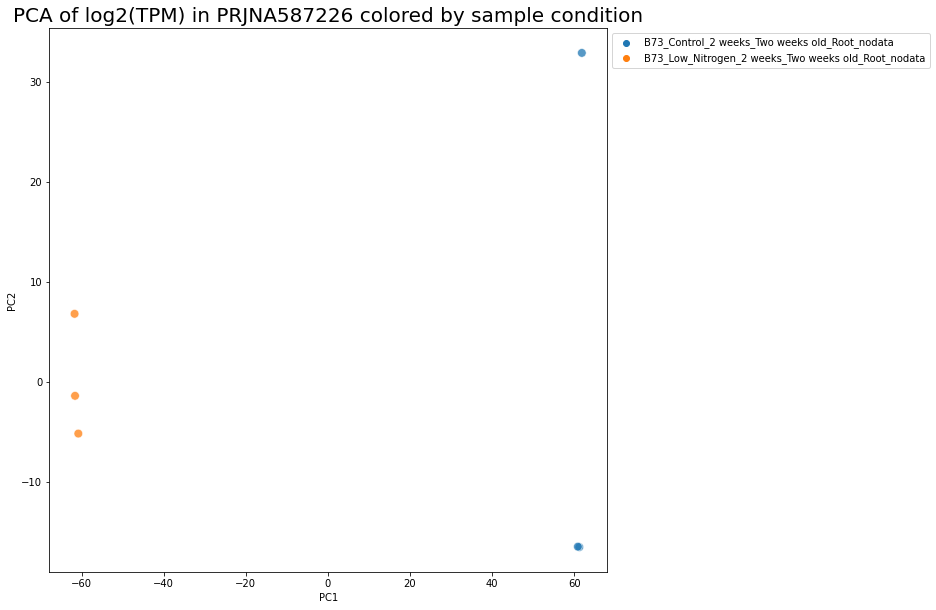

In [54]:
# plot PRJNA587226 by Sample_Condition
fig,ax=plt.subplots(figsize=(10,10))
sns.scatterplot(x=dfdict["PRJNA587226"]["PC1"],y=dfdict["PRJNA587226"]["PC2"],hue=dfdict["PRJNA587226"]["Sample_Condition"],
                palette="tab10",s=75,alpha=0.75)
plt.title("PCA of log2(TPM) in PRJNA587226 colored by sample condition",fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

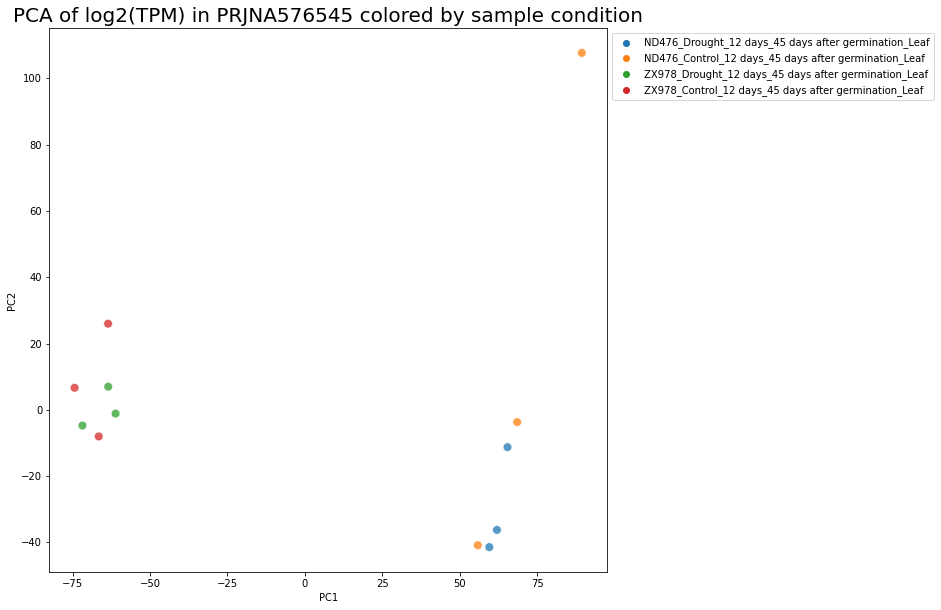

In [55]:
# plot PRJNA576545 by Sample_Condition
fig,ax=plt.subplots(figsize=(10,10))
sns.scatterplot(x=dfdict["PRJNA576545"]["PC1"],y=dfdict["PRJNA576545"]["PC2"],hue=dfdict["PRJNA576545"]["Sample_Condition"],
                palette="tab10",s=75,alpha=0.75)
plt.title("PCA of log2(TPM) in PRJNA576545 colored by sample condition",fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

In [56]:
# for BioProjects with between 20-40 sample conditions, use this code to plot two overlapping colormaps
# start for PRJNA349117 which has 24

half_sampcon = []
count = 0
while count < 20:
    half_sampcon.append(dfdict["PRJNA349117"]["Sample_Condition"].unique()[count])
    count += 1

In [57]:
# generate dataframes each containing part of the sample conditions
plotdf1 = dfdict["PRJNA349117"][dfdict["PRJNA349117"]["Sample_Condition"].isin(half_sampcon)]
plotdf2 = dfdict["PRJNA349117"][~dfdict["PRJNA349117"]["Sample_Condition"].isin(half_sampcon)]

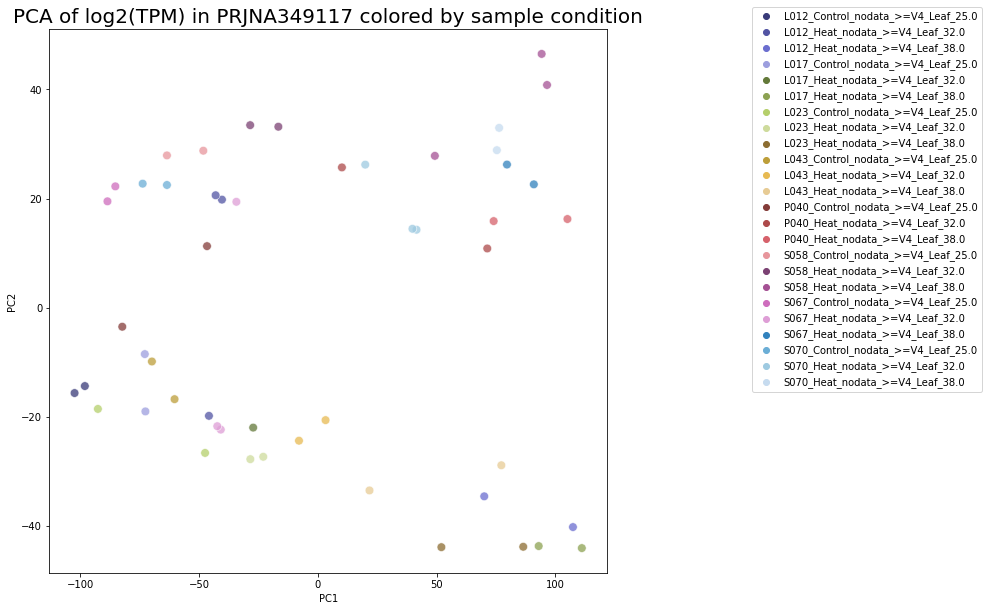

In [58]:
fig,ax=plt.subplots(figsize=(10,10))
sns.scatterplot(x=plotdf1["PC1"],y=plotdf1["PC2"],hue=plotdf1["Sample_Condition"],palette="tab20b",s=75,alpha=0.75)
sns.scatterplot(x=plotdf2["PC1"],y=plotdf2["PC2"],hue=plotdf2["Sample_Condition"],palette="tab20c",s=75,alpha=0.75)
plt.title("PCA of log2(TPM) in PRJNA349117 colored by sample condition",fontsize=20)
plt.legend(bbox_to_anchor=(1.25,1.05))

In [59]:
# now for Brandon's data
half_sampcon = []
count = 0
while count < 20:
    half_sampcon.append(dfdict["Brandon_Webster"]["Sample_Condition"].unique()[count])
    count += 1

In [60]:
plotdf1 = dfdict["Brandon_Webster"][dfdict["Brandon_Webster"]["Sample_Condition"].isin(half_sampcon)]
plotdf2 = dfdict["Brandon_Webster"][~dfdict["Brandon_Webster"]["Sample_Condition"].isin(half_sampcon)]

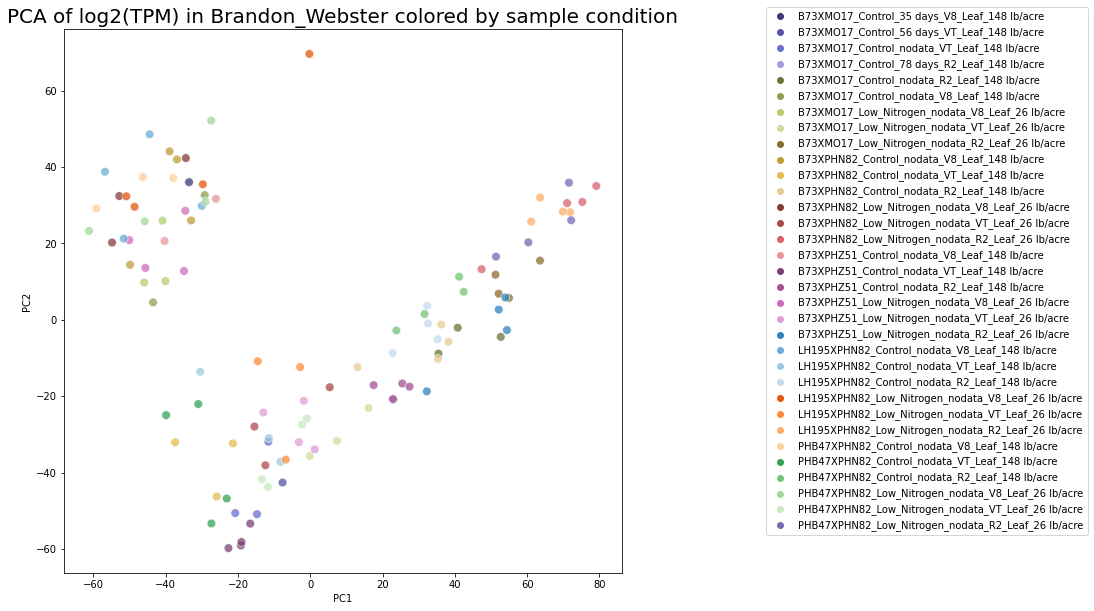

In [61]:
fig,ax=plt.subplots(figsize=(10,10))
sns.scatterplot(x=plotdf1["PC1"],y=plotdf1["PC2"],hue=plotdf1["Sample_Condition"],palette="tab20b",s=75,alpha=0.75)
sns.scatterplot(x=plotdf2["PC1"],y=plotdf2["PC2"],hue=plotdf2["Sample_Condition"],palette="tab20c",s=75,alpha=0.75)
plt.title("PCA of log2(TPM) in Brandon_Webster colored by sample condition",fontsize=20)
plt.legend(bbox_to_anchor=(1.25,1.05))

In [68]:
# for PRJNA747925, split up SampCon column for coloring by, and shape by genotype
half_sampcon = []
count = 0
while count < 20:
    half_sampcon.append(dfdict["PRJNA747925"]["SampCon"].unique()[count])
    count += 1

In [69]:
plotdf1 = dfdict["PRJNA747925"][dfdict["PRJNA747925"]["SampCon"].isin(half_sampcon)]
plotdf2 = dfdict["PRJNA747925"][~dfdict["PRJNA747925"]["SampCon"].isin(half_sampcon)]

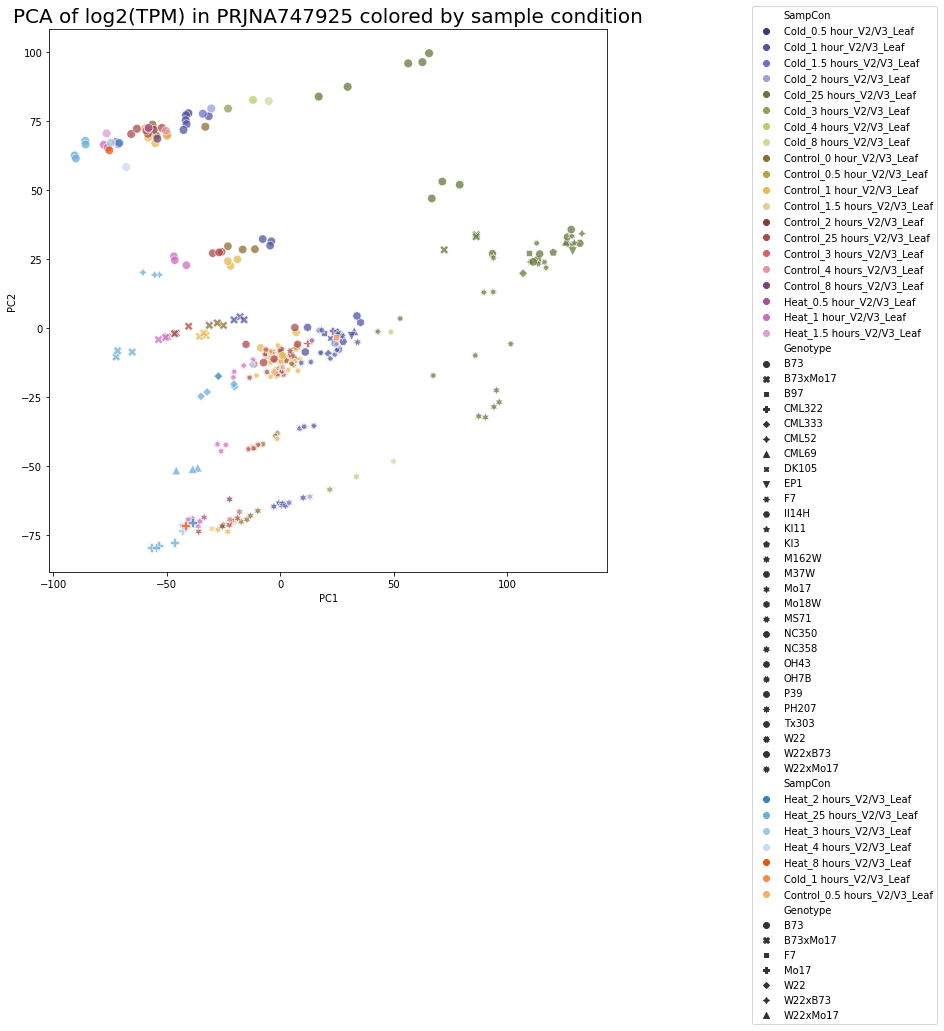

In [89]:
fig,ax=plt.subplots(figsize=(10,10))
sns.scatterplot(x=plotdf1["PC1"],y=plotdf1["PC2"],hue=plotdf1["SampCon"],palette="tab20b",s=75,alpha=0.75,
                style=plotdf1["Genotype"])
sns.scatterplot(x=plotdf2["PC1"],y=plotdf2["PC2"],hue=plotdf2["SampCon"],palette="tab20c",s=75,alpha=0.75,
               style=plotdf2["Genotype"])
plt.title("PCA of log2(TPM) in PRJNA747925 colored by sample condition",fontsize=20)
plt.legend(bbox_to_anchor=(1.25,1.05))

Text(0.5, 1.0, 'By Time Point')

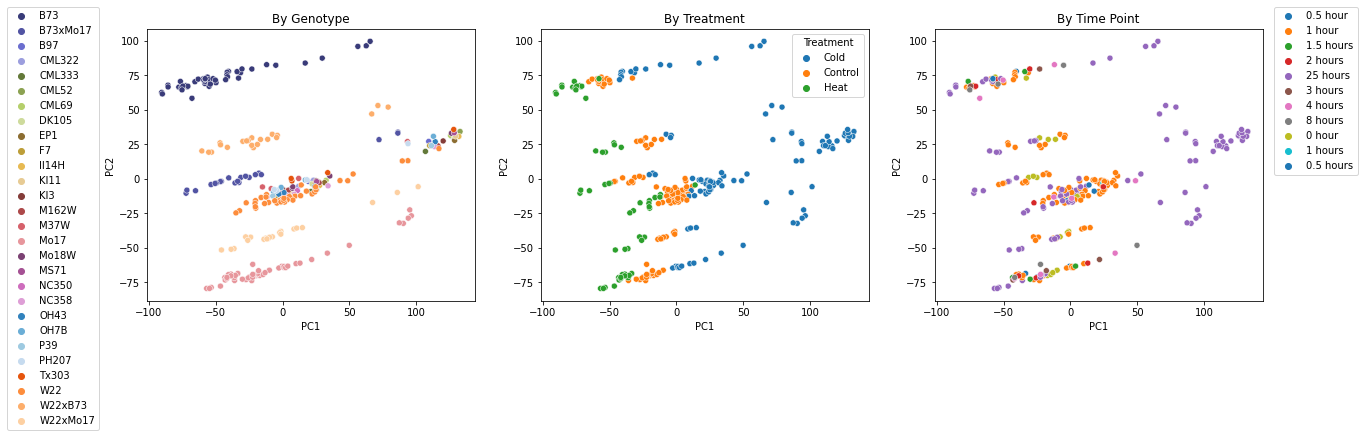

In [108]:
# just do multiple plots for this one
# color by treatment, genotype, and time point

half_gt = []
count = 0
while count < 20:
    half_gt.append(dfdict["PRJNA747925"]["Genotype"].unique()[count])
    count += 1
plotdf1 = dfdict["PRJNA747925"][dfdict["PRJNA747925"]["Genotype"].isin(half_gt)]
plotdf2 = dfdict["PRJNA747925"][~dfdict["PRJNA747925"]["Genotype"].isin(half_gt)]

fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5))

a=sns.scatterplot(ax=ax[0],x=plotdf1["PC1"],y=plotdf1["PC2"],hue=plotdf1["Genotype"],palette="tab20b")
a1 = sns.scatterplot(ax=ax[0],x=plotdf2["PC1"],y=plotdf2["PC2"],hue=plotdf2["Genotype"],palette="tab20c")
a.legend(bbox_to_anchor=(-0.13,1.1))
#a1.legend(bbox_to_anchor=(-0.63,1.1))
a.set_title("By Genotype")

b = sns.scatterplot(ax=ax[1],x=dfdict["PRJNA747925"]["PC1"],y=dfdict["PRJNA747925"]["PC2"],
                    hue=dfdict["PRJNA747925"]["Treatment"])
b.set_title("By Treatment")

c = sns.scatterplot(ax=ax[2],x=dfdict["PRJNA747925"]["PC1"],y=dfdict["PRJNA747925"]["PC2"],
                    hue=dfdict["PRJNA747925"]["Time_after_treatment"],palette="tab10")
c.legend(bbox_to_anchor=(1.02,1.1))
c.set_title("By Time Point")


Text(0.5, 1.0, 'By Treatment')

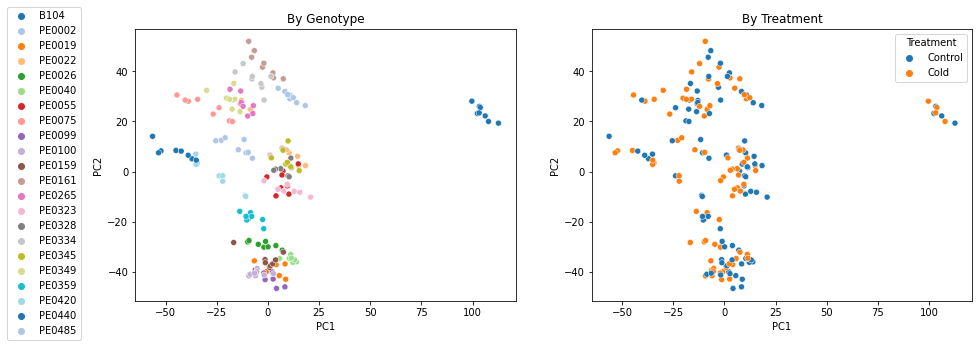

In [114]:
# do the same for PRJNA556806
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
a=sns.scatterplot(ax=ax[0],x=dfdict["PRJNA556806"]["PC1"],y=dfdict["PRJNA556806"]["PC2"],
                  hue=dfdict["PRJNA556806"]["Genotype"],palette="tab20")
a.legend(bbox_to_anchor=(-0.13,1.1))
a.set_title("By Genotype")

b = sns.scatterplot(ax=ax[1],x=dfdict["PRJNA556806"]["PC1"],y=dfdict["PRJNA556806"]["PC2"],
                    hue=dfdict["PRJNA556806"]["Treatment"])
b.set_title("By Treatment")


New question: what if we make PCAs for individual genotypes? (like B73, also Mo17 and W22 if they're in more than one BioProject)

In [121]:
md.columns

Index(['BioProject', 'Sample', 'sample_name', 'Replicate_num', 'Genotype',
       'Technology', 'Library_layout', 'Treatment', 'Duration_hours',
       'Time_after_treatment', 'Concentration_mM', 'Concentration',
       'Developmental_stage', 'Tissue', 'Day_length_hours', 'Day_temp_C',
       'Night_temp_C', 'Relative humidity (%)', 'Light (umol/m2/s)',
       'Growth Env.', 'Media', 'Notes'],
      dtype='object')

In [122]:
# Mo17 is in 2 BioProjects, W22 is in 3
## generate lists of samples in the 3 genotypes of interest (put in a dictionary)
gtsamp = {}
for g in ["Mo17","W22","B73"]:
    df = md[md["Genotype"]==g]
    gtsamp[g] = list(df["Sample"].unique())

In [127]:
# write a function to calculate PCA for each genotype

def gt_run_pca(tpm,genotype,metadata,gtdict):
    print("Running PCA for genotype",genotype)
    # subset TPM dataframe to a single genotype based on the samples from that genotype
    subtpm = tpm[tpm["Sample"].isin(gtdict[genotype])]
    # set Sample as index and drop BioProject and Treatment columns
    ttpm = subtpm.set_index("Sample").drop(["BioProject","Treatment"],axis=1)
    # put through VarianceThreshold() using the variance_threshold_selector() defined above
    vttpm = variance_threshold_selector(ttpm)
    # find how many zero-variance genes were eliminated
    print("Number of zero-variance genes eliminated:",len(ttpm.columns)-len(vttpm.columns))
    # log-transform TPM
    vttpm_log = vttpm.apply(lambda x: np.log2(x+1))
    # run PCA and generate dataframe with PCs
    pca = PCA(n_components=2)
    real_PCs = pca.fit_transform(vttpm_log)
    real_PCs_df = pd.DataFrame(data = real_PCs, columns = ['PC1','PC2'])
    # find the explained variance ratio
    print("PCA explained variance ratio:",pca.explained_variance_ratio_)
    ## reset index (after running PCA)
    vttpm_log.reset_index(inplace=True)
    vttpm_log.rename(columns={"index":"Sample"},inplace=True)
    # merge with metadata
    ## note this has to maintain the sample order of vttpm_log, otherwise when we concatenate it with the PC df everything will 
    ## be incorrectly matched up
    vttpm_log_merged = vttpm_log.merge(metadata,how="inner")
    # append metadata to PCA df
    plotdf = pd.concat([real_PCs_df,vttpm_log_merged[["BioProject","Genotype","Treatment","Time_after_treatment","Concentration",
                                                     "Developmental_stage","Tissue","Day_length_hours","Day_temp_C","Night_temp_C",
                                                     "Relative humidity (%)","Light (umol/m2/s)","Growth Env.","Media"]]],axis=1)
    # rename DroughtRepeat to Drought
    plotdf["Treatment"].mask(plotdf["Treatment"]=="DroughtRepeat","Drought",inplace=True)
    
    return plotdf
    

In [128]:
gtdfdict = {}
for g in gtsamp.keys():
    gtdfdict[g] = gt_run_pca(tpm,g,md,gtsamp)

Running PCA for genotype Mo17
Number of zero-variance genes eliminated: 5539
PCA explained variance ratio: [0.67603123 0.10541489]
Running PCA for genotype W22
Number of zero-variance genes eliminated: 4001
PCA explained variance ratio: [0.32290836 0.18405232]
Running PCA for genotype B73
Number of zero-variance genes eliminated: 388
PCA explained variance ratio: [0.26379625 0.20150855]


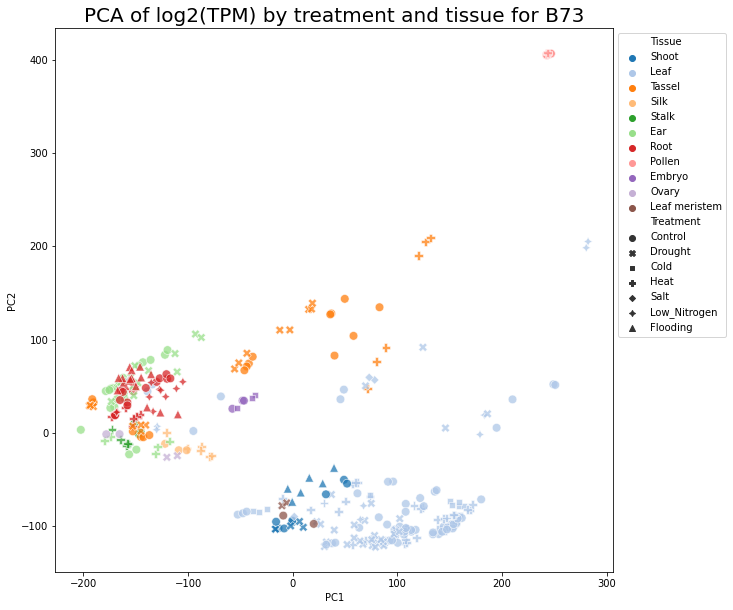

In [137]:
# start by plotting the PCA for B73 samples colored by treatment - we want to know if samples group by treatment within each
## genotype

fig,ax=plt.subplots(figsize=(10,10))
sns.scatterplot(x=gtdfdict["B73"]["PC1"],y=gtdfdict["B73"]["PC2"],hue=gtdfdict["B73"]["Tissue"],palette="tab20",s=75,alpha=0.75,
               style=gtdfdict["B73"]["Treatment"])
plt.title("PCA of log2(TPM) by treatment and tissue for B73",fontsize=20)
plt.legend(bbox_to_anchor=(1,1))


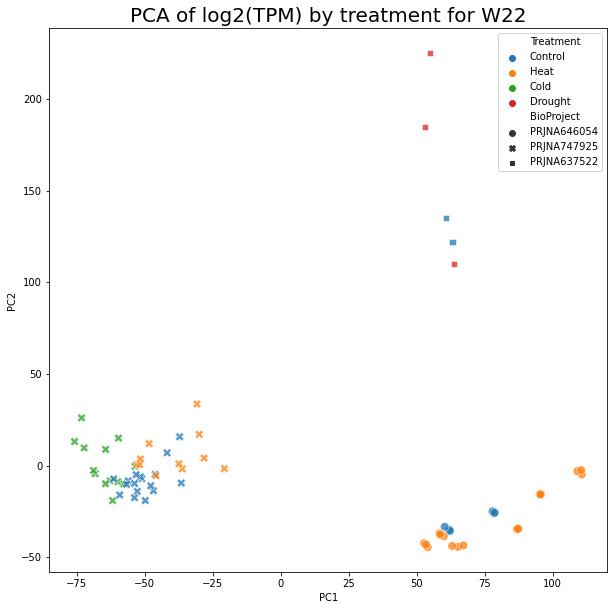

In [141]:
# let's look at W22 now
fig,ax=plt.subplots(figsize=(10,10))
sns.scatterplot(x=gtdfdict["W22"]["PC1"],y=gtdfdict["W22"]["PC2"],hue=gtdfdict["W22"]["Treatment"],palette="tab10",s=75,alpha=0.75,
               style=gtdfdict["W22"]["BioProject"])
plt.title("PCA of log2(TPM) by treatment for W22",fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

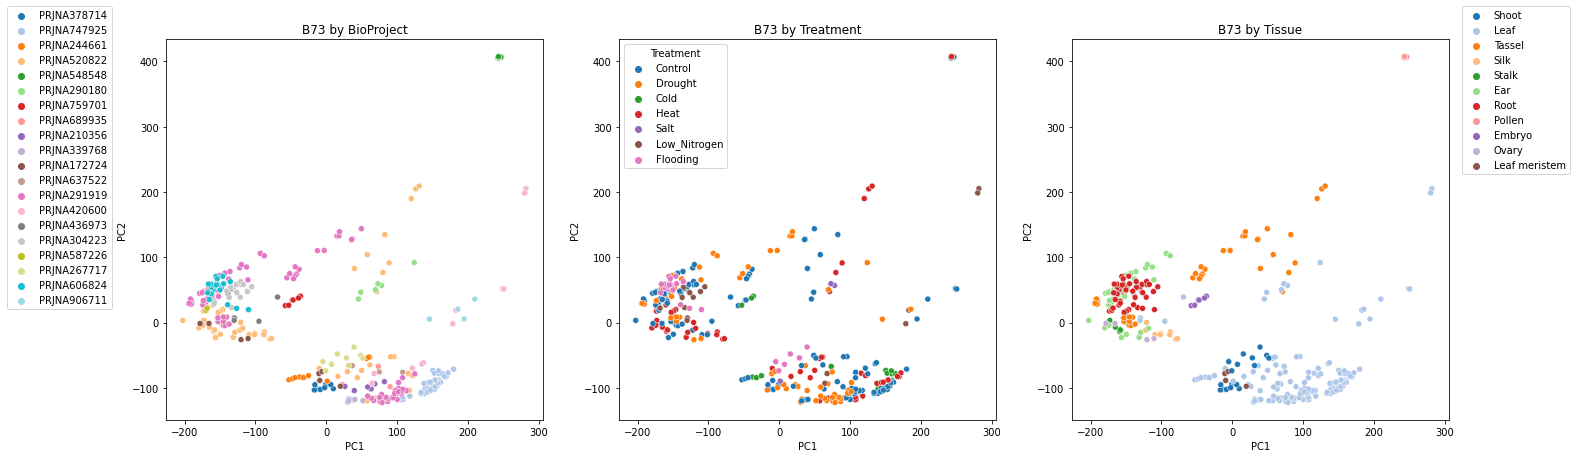

In [149]:
# for B73, plot again, but subplots for tissue, treatment, and BioProject
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(23,7))
a=sns.scatterplot(ax=ax[0],x=gtdfdict["B73"]["PC1"],y=gtdfdict["B73"]["PC2"],
                  hue=gtdfdict["B73"]["BioProject"],palette="tab20")
a.legend(bbox_to_anchor=(-0.13,1.1))
a.set_title("B73 by BioProject")

b = sns.scatterplot(ax=ax[1],x=gtdfdict["B73"]["PC1"],y=gtdfdict["B73"]["PC2"],
                    hue=gtdfdict["B73"]["Treatment"])
b.set_title("B73 by Treatment")

c = sns.scatterplot(ax=ax[2],x=gtdfdict["B73"]["PC1"],y=gtdfdict["B73"]["PC2"],hue=gtdfdict["B73"]["Tissue"],palette="tab20")
c.set_title("B73 by Tissue")
c.legend(bbox_to_anchor=(1.02,1.1))

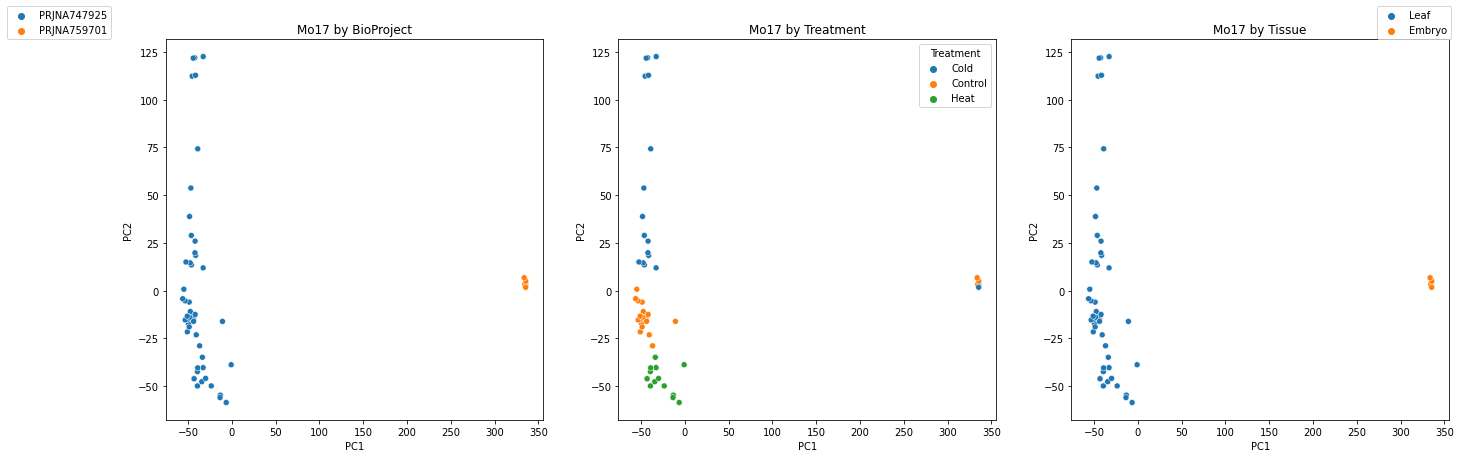

In [151]:
# do the same for Mo17
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(23,7))
a=sns.scatterplot(ax=ax[0],x=gtdfdict["Mo17"]["PC1"],y=gtdfdict["Mo17"]["PC2"],
                  hue=gtdfdict["Mo17"]["BioProject"],palette="tab10")
a.legend(bbox_to_anchor=(-0.13,1.1))
a.set_title("Mo17 by BioProject")

b = sns.scatterplot(ax=ax[1],x=gtdfdict["Mo17"]["PC1"],y=gtdfdict["Mo17"]["PC2"],
                    hue=gtdfdict["Mo17"]["Treatment"])
b.set_title("Mo17 by Treatment")

c = sns.scatterplot(ax=ax[2],x=gtdfdict["Mo17"]["PC1"],y=gtdfdict["Mo17"]["PC2"],hue=gtdfdict["Mo17"]["Tissue"],palette="tab10")
c.set_title("Mo17 by Tissue")
c.legend(bbox_to_anchor=(1.02,1.1))

New work Nov. 17, 2023: Run and plot a PCA for B73, Mo17, and W22 all together to see how much they group by genotype vs. other factors

In [153]:
# make a single list of all samples for these three genotypes
bmwsamp = gtsamp["B73"]+gtsamp["Mo17"]+gtsamp["W22"]

In [154]:
# subset TPM to only the relevant samples
## how many samples is this?
bmwtpm = tpm[tpm["Sample"].isin(bmwsamp)]
len(bmwtpm["Sample"])

479

In [155]:
# set Sample as index and drop BioProject and Treatment columns
ttpm = bmwtpm.set_index("Sample").drop(["BioProject","Treatment"],axis=1)
# put through VarianceThreshold() using the variance_threshold_selector() defined above
vttpm = variance_threshold_selector(ttpm)

In [156]:
# find how many zero-variance genes were eliminated
len(ttpm.columns)-len(vttpm.columns)

283

In [157]:
# log-transform TPM
vttpm_log = vttpm.apply(lambda x: np.log2(x+1))
# run PCA and generate dataframe with PCs
pca = PCA(n_components=2)
real_PCs = pca.fit_transform(vttpm_log)
real_PCs_df = pd.DataFrame(data = real_PCs, columns = ['PC1','PC2'])

In [158]:
# find the explained variance ratio
pca.explained_variance_ratio_

array([0.29788436, 0.16978468])

In [159]:
## reset index (after running PCA)
vttpm_log.reset_index(inplace=True)
vttpm_log.rename(columns={"index":"Sample"},inplace=True)
vttpm_log_merged = vttpm_log.merge(md,how="inner")
# append metadata to PCA df
plotdf = pd.concat([real_PCs_df,vttpm_log_merged[["BioProject","Genotype","Treatment","Time_after_treatment","Concentration",
                                                 "Developmental_stage","Tissue","Day_length_hours","Day_temp_C","Night_temp_C",
                                                 "Relative humidity (%)","Light (umol/m2/s)","Growth Env.","Media"]]],axis=1)

In [160]:
# rename DroughtRepeat to Drought
plotdf["Treatment"].mask(plotdf["Treatment"]=="DroughtRepeat","Drought",inplace=True)

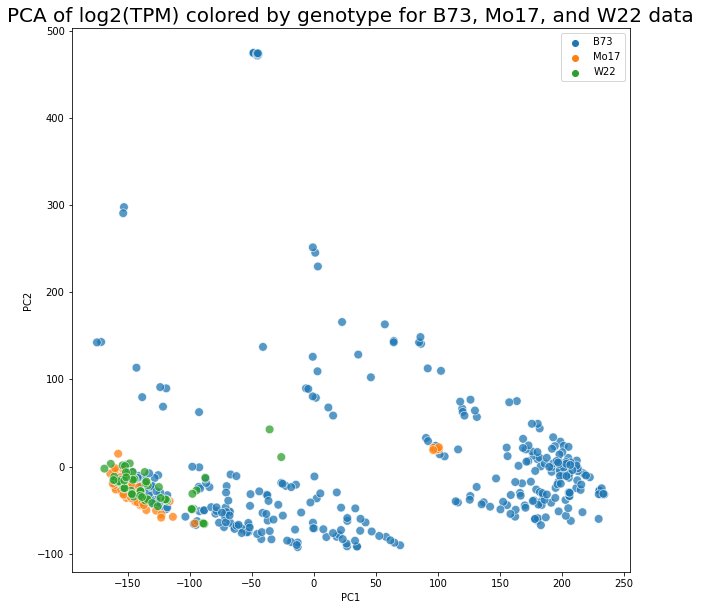

In [161]:
# plot data by genotype
fig,ax=plt.subplots(figsize=(10,10))
sns.scatterplot(x=plotdf["PC1"],y=plotdf["PC2"],hue=plotdf["Genotype"],palette="tab10",s=75,alpha=0.75)
plt.title("PCA of log2(TPM) colored by genotype for B73, Mo17, and W22 data",fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

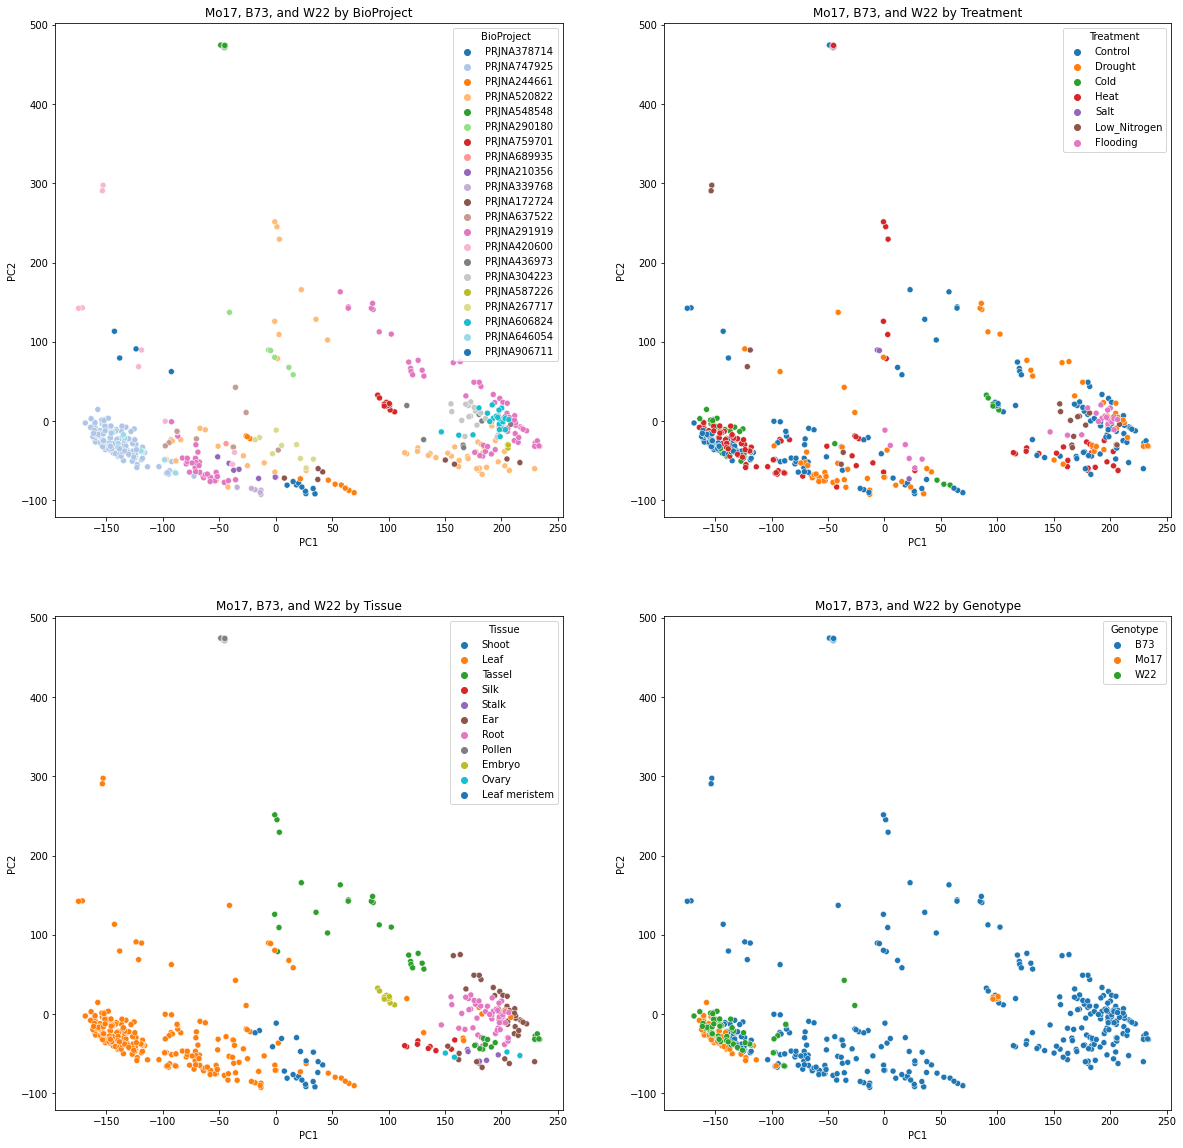

In [165]:
# plot by genotype, tissue, BioProject, and treatment
fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(20,20))
a=sns.scatterplot(ax=ax[0,0],x=plotdf["PC1"],y=plotdf["PC2"],hue=plotdf["BioProject"],palette="tab20")
#a.legend(bbox_to_anchor=(-0.13,1.1))
a.set_title("Mo17, B73, and W22 by BioProject")

b = sns.scatterplot(ax=ax[0,1],x=plotdf["PC1"],y=plotdf["PC2"],hue=plotdf["Treatment"],palette="tab10")
b.set_title("Mo17, B73, and W22 by Treatment")
#b.legend(bbox_to_anchor=(1.02,1.1))

c = sns.scatterplot(ax=ax[1,0],x=plotdf["PC1"],y=plotdf["PC2"],hue=plotdf["Tissue"],palette="tab10")
c.set_title("Mo17, B73, and W22 by Tissue")

d = sns.scatterplot(ax=ax[1,1],x=plotdf["PC1"],y=plotdf["PC2"],hue=plotdf["Genotype"],palette="tab10")
d.set_title("Mo17, B73, and W22 by Genotype")

plt.savefig("../../figures/QC_PCA_Mo17_B73_W22.pdf",bbox_inches="tight")